# Lecture 5 Evaluation Exercise: M/G/2 Case Study (Generator)

This notebook is for the **instructor**. It generates the synthetic log used in the Lecture 5 evaluation exercise: an $M/G/2$ queue with Poisson arrivals and truncated exponential service times.

- True model: $M/G/2$ with $\lambda = 1/\pi$ and service $S \sim \mathrm{Exp}(1) \mid S > \gamma$ (Euler's constant).
- The dataset written to `data/lecture5_mg2_case_study.csv` is what students see.


In [1]:
import numpy as np
import pandas as pd
import math
import os

EULER_GAMMA = 0.5772156649015329  # Euler–Mascheroni constant

def generate_mg2_trunc_exp_dataset(T: float,
                                   lam: float,
                                   mu: float,
                                   seed: int = 123,
                                   max_servers: int = 2) -> pd.DataFrame:
    """Generate per-job dataset for an M/G/2 queue.

    Arrivals follow a Poisson process of rate ``lam`` and services are
    i.i.d. with distribution
        S = EULER_GAMMA + Exp(mu),
    i.e. an exponential of rate ``mu`` conditioned on being larger than
    Euler's constant.

    The output has one row per job with columns:
    arrival_time, queue_len_at_arrival, service_time, start_service_time,
    completion_time, wait_time, system_time.
    """
    rng = np.random.default_rng(seed)
    t = 0.0
    next_arrival = t + rng.exponential(1.0 / lam)

    # Active jobs currently in service (at most max_servers)
    servers = []  # list of job dicts with a 'completion_time' field
    queue = []    # FIFO queue of waiting jobs (job dicts)
    rows = []

    def start_service(now: float, job: dict) -> None:
        """Start service for a job on one of the servers."""
        s = EULER_GAMMA + rng.exponential(1.0 / mu)
        job["service_time"] = float(s)
        job["start_service_time"] = float(now)
        job["completion_time"] = float(now + s)
        servers.append(job)

    while True:
        # Next completion among busy servers (if any)
        next_completion = min(
            (job["completion_time"] for job in servers),
            default=math.inf,
        )
        t_next = min(next_arrival, next_completion)
        if t_next == math.inf:
            break
        t = t_next

        if next_arrival <= next_completion:
            # Arrival event
            if t <= T:
                q_len = len(queue) + len(servers)
                job = {
                    "arrival_time": float(t),
                    "queue_len_at_arrival": int(q_len),
                }
                if len(servers) < max_servers:
                    start_service(t, job)
                else:
                    queue.append(job)
            # Schedule next arrival
            next_arrival = t + rng.exponential(1.0 / lam)
        else:
            # Completion event: select job with smallest completion time
            idx = min(range(len(servers)), key=lambda i: servers[i]["completion_time"])
            job = servers.pop(idx)
            if job["arrival_time"] <= T:
                completion_time = job["completion_time"]
                row = {
                    "arrival_time": job["arrival_time"],
                    "queue_len_at_arrival": job["queue_len_at_arrival"],
                    "service_time": job["service_time"],
                    "start_service_time": job["start_service_time"],
                    "completion_time": completion_time,
                    "wait_time": max(0.0, job["start_service_time"] - job["arrival_time"]),
                    "system_time": completion_time - job["arrival_time"],
                }
                rows.append(row)
            # If there is a waiting job, start it immediately on the freed server
            if queue:
                next_job = queue.pop(0)
                start_service(t, next_job)

        # Terminate once there are no future arrivals and the system is empty
        if next_arrival > T and not servers and not queue and t >= T:
            break

    return pd.DataFrame(
        rows,
        columns=[
            "arrival_time",
            "queue_len_at_arrival",
            "service_time",
            "start_service_time",
            "completion_time",
            "wait_time",
            "system_time",
        ],
    )

# Parameters and dataset generation
LAMBDA_TRUE = 1.0 / math.pi
MU_TRUE = 1.0
T = 4000.0

DATA_PATH = "data/lecture5_mg2_case_study.csv"
os.makedirs("data", exist_ok=True)

df = generate_mg2_trunc_exp_dataset(T=T, lam=LAMBDA_TRUE, mu=MU_TRUE, seed=2025)
df.to_csv(DATA_PATH, index=False)
print(f"Generated dataset: {DATA_PATH} with {len(df)} rows.")

# Quick sanity check on basic estimates
T_obs = float(df["arrival_time"].max())
lam_hat = len(df) / T_obs
m1_hat = float(df["service_time"].mean())
rho_hat = lam_hat * m1_hat / 2.0
print(f"Rough check: lambda_hat={lam_hat:.4f}, m1_hat={m1_hat:.4f}, rho_hat={rho_hat:.4f}")


Generated dataset: data/lecture5_mg2_case_study.csv with 1226 rows.
Rough check: lambda_hat=0.3066, m1_hat=1.5565, rho_hat=0.2386


## Instructor Solution Outline

This section gives a worked solution for the evaluation exercise, using the main tools from Lectures 2–4 and commenting explicitly on *why* each step is taken.

- **Arrival process (Poisson model):**
  We estimate the arrival rate $\hat\lambda$ from counts on $[0,T]$ and form an asymptotic CI using the Poisson variance $\Var(\hat\lambda) \approx \lambda/T$. We then check the modelling assumptions with inter-arrival histograms, log-survival plots, and rate-by-subinterval diagnostics to see whether a homogeneous Poisson process is reasonable.
- **Service-time model (offset + exponential tail):**
  We treat service times as fixed overhead plus an exponential tail, $S = s_0 + \mathrm{Exp}(\mu)$, to capture a deterministic setup cost followed by memoryless processing time. We estimate $s_0$ from the minimum observed service time and fit $\mu$ by MLE on the shifted data, then compare the model to the empirical distribution via histogram, ECDF, and log-survival plots.
- **Performance metrics ($W_q$, $L_q$, utilisation):**
  Using the fitted model and two servers, we compute utilisation $\hat\rho = \hat\lambda \hat m_1 / 2$, empirical mean waiting time $\overline W_q$, and the mean number in queue $L_q$ from arrivals (using queue_len_at_arrival) and via Little's Law $L_q \approx \hat\lambda\,\overline W_q$. This checks internal consistency of the model and data.
- **Simulation-based uncertainty and comparison:**
  We simulate the fitted $M/G/2$ model repeatedly, compute the run-level averages of $W_q$ and $L_q$, and use the CLT over replications to obtain 95\% confidence intervals: $\hat m \pm 1.96\,\hat s/\sqrt{B}$, where $\hat m$ is the mean of the $B$ replication means and $\hat s$ their sample standard deviation. The final figure overlays these simulation-based distributions (a parametric bootstrap under the fitted model) and CIs with the empirical estimates to visually assess how well the fitted model explains the observed performance and where it might miss.


Arrival rate: lambda_hat=0.3066 (95% CI [0.2895, 0.3238])


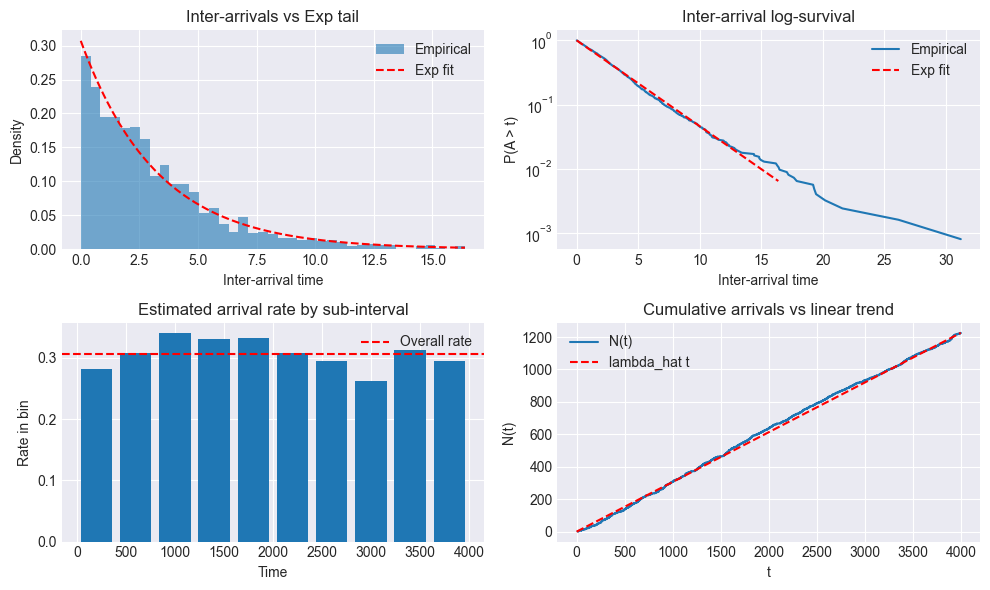

Service model: S = s0 + Exp(mu) with s0_hat=0.5779
  mu_hat=1.0219 (95% CI [0.9647, 1.0791]),  m1_model=1.5565


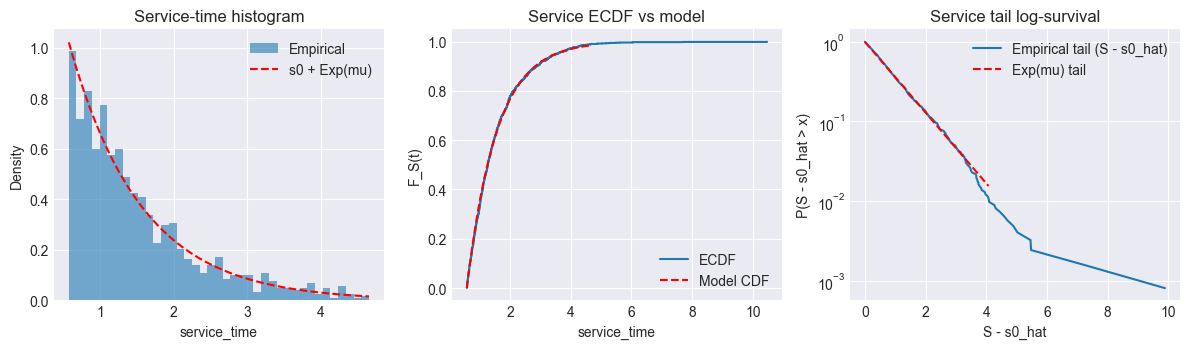

Fraction of zero waits = 0.907,  mean wait given Wq>0 = 0.8768
Utilisation (model-based): rho_hat=0.2386
Empirical mean wait Wq_emp=0.0815
Empirical Lq from arrivals (using queue_len_at_arrival): Lq_emp=0.0367
Little's Law estimate: Lq_LL=lambda_hat * Wq_emp=0.0250

Simulation-based performance for fitted M/G/2 model:
  Wq_mc=0.0688 (95% CI [0.0668, 0.0708]),  empirical Wq=0.0815
  Lq_mc=0.0214 (95% CI [0.0202, 0.0227]),  empirical Lq=0.0367


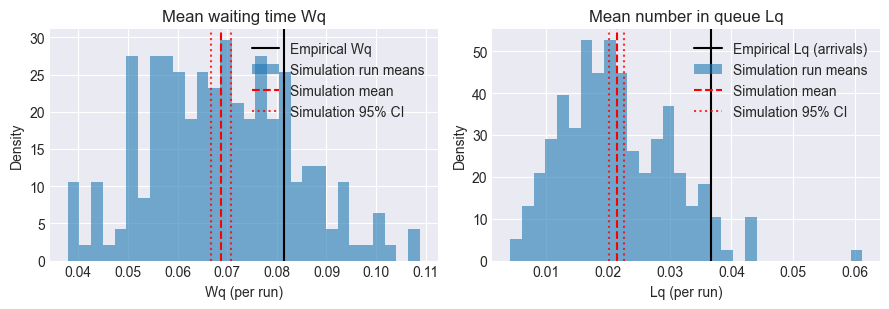

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")

# Work from the dataset generated above (df)

Z_95 = 1.959963984540054  # ~N(0,1) 97.5% quantile

### 1. Arrival process: Poisson rate and CI
T_obs = float(df["arrival_time"].max())  # observation horizon [0, T]
n_jobs = len(df)
lambda_hat = n_jobs / T_obs
se_lambda = math.sqrt(max(lambda_hat, 1e-12) / T_obs)
lam_lo = lambda_hat - Z_95 * se_lambda
lam_hi = lambda_hat + Z_95 * se_lambda

print(f"Arrival rate: lambda_hat={lambda_hat:.4f} (95% CI [{lam_lo:.4f}, {lam_hi:.4f}])")

# Arrival diagnostics: inter-arrival distribution and stationarity
arrival_times = np.sort(df["arrival_time"].to_numpy())
inter_arrivals = np.diff(arrival_times)
mean_ia = inter_arrivals.mean()
rate_from_ia = 1.0 / max(mean_ia, 1e-12)

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# (1,1) histogram of inter-arrivals with Exp overlay
ax = axes[0, 0]
bins = np.linspace(0, np.quantile(inter_arrivals, 0.99), 40)
ax.hist(inter_arrivals, bins=bins, density=True, alpha=0.6, label="Empirical")
grid = np.linspace(0, bins[-1], 200)
ax.plot(grid, rate_from_ia * np.exp(-rate_from_ia * grid), "r--", label="Exp fit")
ax.set_title("Inter-arrivals vs Exp tail")
ax.set_xlabel("Inter-arrival time")
ax.set_ylabel("Density")
ax.legend()

# (1,2) log-survival of inter-arrivals
ax = axes[0, 1]
sorted_ia = np.sort(inter_arrivals)
surv = 1.0 - np.arange(1, len(sorted_ia) + 1) / (len(sorted_ia) + 1)
ax.plot(sorted_ia, surv, label="Empirical")
ax.plot(grid, np.exp(-rate_from_ia * grid), "r--", label="Exp fit")
ax.set_yscale("log")
ax.set_title("Inter-arrival log-survival")
ax.set_xlabel("Inter-arrival time")
ax.set_ylabel("P(A > t)")
ax.legend()

# (2,1) arrivals per time-slice (rate over time)
ax = axes[1, 0]
K = 10
edges = np.linspace(0.0, T_obs, K + 1)
counts, _ = np.histogram(arrival_times, bins=edges)
centres = 0.5 * (edges[:-1] + edges[1:])
ax.bar(centres, counts / (T_obs / K), width=T_obs / K * 0.8)
ax.axhline(lambda_hat, color="r", linestyle="--", label="Overall rate")
ax.set_title("Estimated arrival rate by sub-interval")
ax.set_xlabel("Time")
ax.set_ylabel("Rate in bin")
ax.legend()

# (2,2) cumulative arrivals vs time
ax = axes[1, 1]
ax.step(arrival_times, np.arange(1, len(arrival_times) + 1), where="post", label="N(t)")
ax.plot([0, T_obs], [0, lambda_hat * T_obs], "r--", label="lambda_hat t")
ax.set_title("Cumulative arrivals vs linear trend")
ax.set_xlabel("t")
ax.set_ylabel("N(t)")
ax.legend()

plt.tight_layout()
plt.show()

### 2. Service-time model: offset + exponential tail
S = df["service_time"].to_numpy()
s0_hat = float(S.min())  # simple estimate of fixed overhead
Y = S - s0_hat
mu_hat = 1.0 / max(Y.mean(), 1e-12)  # rate of Exp(mu) for tail
se_mu = mu_hat / math.sqrt(max(len(Y), 1))
mu_lo = mu_hat - Z_95 * se_mu
mu_hi = mu_hat + Z_95 * se_mu

# Implied first moment for S = s0 + Exp(mu)
m1_model = s0_hat + 1.0 / mu_hat

print(f"Service model: S = s0 + Exp(mu) with s0_hat={s0_hat:.4f}")
print(f"  mu_hat={mu_hat:.4f} (95% CI [{mu_lo:.4f}, {mu_hi:.4f}]),  m1_model={m1_model:.4f}")

# Service-time diagnostics
fig, axes = plt.subplots(1, 3, figsize=(12, 3.6))

# (1) histogram with model overlay
ax = axes[0]
bins_S = np.linspace(S.min(), np.quantile(S, 0.99), 40)
ax.hist(S, bins=bins_S, density=True, alpha=0.6, label="Empirical")
grid_S = np.linspace(bins_S[0], bins_S[-1], 300)
dens_model = np.where(grid_S >= s0_hat, mu_hat * np.exp(-mu_hat * (grid_S - s0_hat)), 0.0)
ax.plot(grid_S, dens_model, "r--", label="s0 + Exp(mu)")
ax.set_title("Service-time histogram")
ax.set_xlabel("service_time")
ax.set_ylabel("Density")
ax.legend()

# (2) ECDF vs model CDF
ax = axes[1]
S_sorted = np.sort(S)
ecdf = np.arange(1, len(S_sorted) + 1) / (len(S_sorted) + 1)
ax.step(S_sorted, ecdf, where="post", label="ECDF")
cdf_model = np.where(grid_S < s0_hat, 0.0, 1.0 - np.exp(-mu_hat * (grid_S - s0_hat)))
ax.plot(grid_S, cdf_model, "r--", label="Model CDF")
ax.set_title("Service ECDF vs model")
ax.set_xlabel("service_time")
ax.set_ylabel("F_S(t)")
ax.legend()

# (3) log-survival of tail
ax = axes[2]
Y_sorted = np.sort(Y)
surv_S = 1.0 - np.arange(1, len(Y_sorted) + 1) / (len(Y_sorted) + 1)
ax.plot(Y_sorted, surv_S, label="Empirical tail (S - s0_hat)")
ax.plot(grid_S - s0_hat, np.exp(-mu_hat * (grid_S - s0_hat)), "r--", label="Exp(mu) tail")
ax.set_yscale("log")
ax.set_title("Service tail log-survival")
ax.set_xlabel("S - s0_hat")
ax.set_ylabel("P(S - s0_hat > x)")
ax.legend()

plt.tight_layout()
plt.show()

### 3. Utilisation and empirical performance (Wq, Lq)
servers = 2
rho_model = lambda_hat * m1_model / servers
Wq_emp = float(df["wait_time"].mean())
Lq_emp_arrivals = float(np.maximum(df["queue_len_at_arrival"].to_numpy() - servers, 0).mean())
Lq_ll_emp = lambda_hat * Wq_emp

# Sanity check: include jobs with zero wait in Wq_emp
zero_wait_frac = float((df["wait_time"] == 0.0).mean())
Wq_positive = float(df.loc[df["wait_time"] > 0.0, "wait_time"].mean()) if (df["wait_time"] > 0.0).any() else 0.0
print(f"Fraction of zero waits = {zero_wait_frac:.3f},  mean wait given Wq>0 = {Wq_positive:.4f}")

print(f"Utilisation (model-based): rho_hat={rho_model:.4f}")
print(f"Empirical mean wait Wq_emp={Wq_emp:.4f}")
print(f"Empirical Lq from arrivals (using queue_len_at_arrival): Lq_emp={Lq_emp_arrivals:.4f}")
print(f"Little's Law estimate: Lq_LL=lambda_hat * Wq_emp={Lq_ll_emp:.4f}")

### 4. Simulation-based Wq and Lq for the fitted model (M/G/2)
def generate_mg2_offset_exp_dataset(T: float,
                                   lam: float,
                                   s0: float,
                                   mu: float,
                                   seed: int = 123,
                                   max_servers: int = 2) -> pd.DataFrame:
    """M/G/2 with S = s0 + Exp(mu); returns per-job log like the student dataset."""
    rng = np.random.default_rng(seed)
    t = 0.0
    next_arrival = t + rng.exponential(1.0 / lam)
    servers = []  # active jobs in service
    queue = []
    rows = []

    def start_service(now: float, job: dict) -> None:
        s = s0 + rng.exponential(1.0 / mu)
        job["service_time"] = float(s)
        job["start_service_time"] = float(now)
        job["completion_time"] = float(now + s)
        servers.append(job)

    while True:
        next_completion = min((job["completion_time"] for job in servers), default=math.inf)
        t_next = min(next_arrival, next_completion)
        if t_next == math.inf:
            break
        t = t_next

        if next_arrival <= next_completion:
            if t <= T:
                q_len = len(queue) + len(servers)
                job = {
                    "arrival_time": float(t),
                    "queue_len_at_arrival": int(q_len),
                }
                if len(servers) < max_servers:
                    start_service(t, job)
                else:
                    queue.append(job)
            next_arrival = t + rng.exponential(1.0 / lam)
        else:
            idx = min(range(len(servers)), key=lambda i: servers[i]["completion_time"])
            job = servers.pop(idx)
            if job["arrival_time"] <= T:
                completion_time = job["completion_time"]
                row = {
                    "arrival_time": job["arrival_time"],
                    "queue_len_at_arrival": job["queue_len_at_arrival"],
                    "service_time": job["service_time"],
                    "start_service_time": job["start_service_time"],
                    "completion_time": completion_time,
                    "wait_time": max(0.0, job["start_service_time"] - job["arrival_time"]),
                    "system_time": completion_time - job["arrival_time"],
                }
                rows.append(row)
            if queue:
                next_job = queue.pop(0)
                start_service(t, next_job)

        if next_arrival > T and not servers and not queue and t >= T:
            break

    return pd.DataFrame(rows)


def simulate_performance(T: float,
                         lam: float,
                         s0: float,
                         mu: float,
                         reps: int = 200,
                         seed: int = 2025):
    rng = np.random.default_rng(seed)
    Wq_samples = []
    Lq_samples = []
    for _ in range(reps):
        df_sim = generate_mg2_offset_exp_dataset(T, lam, s0, mu,
                                                seed=int(rng.integers(0, 2**31 - 1)))
        Wq_samples.append(float(df_sim["wait_time"].mean()))
        Lq_samples.append(float(np.maximum(df_sim["queue_len_at_arrival"].to_numpy() - servers, 0).mean()))
    Wq_samples = np.array(Wq_samples)
    Lq_samples = np.array(Lq_samples)
    Wq_mean, Wq_se = Wq_samples.mean(), Wq_samples.std(ddof=1) / math.sqrt(reps)
    Lq_mean, Lq_se = Lq_samples.mean(), Lq_samples.std(ddof=1) / math.sqrt(reps)
    return (Wq_mean, Wq_se, Wq_samples), (Lq_mean, Lq_se, Lq_samples)


(Wq_mc, Wq_se, Wq_samples), (Lq_mc, Lq_se, Lq_samples) = simulate_performance(T_obs, lambda_hat, s0_hat, mu_hat)
# CLT-based 95% CI over replication means for Wq and Lq
Wq_lo, Wq_hi = Wq_mc - Z_95 * Wq_se, Wq_mc + Z_95 * Wq_se
Lq_lo, Lq_hi = Lq_mc - Z_95 * Lq_se, Lq_mc + Z_95 * Lq_se

print("\nSimulation-based performance for fitted M/G/2 model:")
print(f"  Wq_mc={Wq_mc:.4f} (95% CI [{Wq_lo:.4f}, {Wq_hi:.4f}]),  empirical Wq={Wq_emp:.4f}")
print(f"  Lq_mc={Lq_mc:.4f} (95% CI [{Lq_lo:.4f}, {Lq_hi:.4f}]),  empirical Lq={Lq_emp_arrivals:.4f}")

# Visual comparison: empirical vs model-based summaries
fig, axes = plt.subplots(1, 2, figsize=(9, 3.2))

# (1) Wq: empirical vs simulation distribution of run means
ax = axes[0]
ax.axvline(Wq_emp, color="k", linestyle="-", label="Empirical Wq")
ax.hist(Wq_samples, bins=30, density=True, alpha=0.6, label="Simulation run means")
ax.axvline(Wq_mc, color="r", linestyle="--", label="Simulation mean")
ax.axvline(Wq_lo, color="r", linestyle=":", alpha=0.8, label="Simulation 95% CI")
ax.axvline(Wq_hi, color="r", linestyle=":", alpha=0.8)
ax.set_title("Mean waiting time Wq")
ax.set_xlabel("Wq (per run)")
ax.set_ylabel("Density")
ax.legend()

# (2) Lq: empirical vs simulation distribution of run means
ax = axes[1]
ax.axvline(Lq_emp_arrivals, color="k", linestyle="-", label="Empirical Lq (arrivals)")
ax.hist(Lq_samples, bins=30, density=True, alpha=0.6, label="Simulation run means")
ax.axvline(Lq_mc, color="r", linestyle="--", label="Simulation mean")
ax.axvline(Lq_lo, color="r", linestyle=":", alpha=0.8, label="Simulation 95% CI")
ax.axvline(Lq_hi, color="r", linestyle=":", alpha=0.8)
ax.set_title("Mean number in queue Lq")
ax.set_xlabel("Lq (per run)")
ax.set_ylabel("Density")
ax.legend()

plt.tight_layout()
plt.show()


## Reading the Results: A Short Investigation

To turn the raw numbers into insight, it helps to walk through the outputs step by step and ask: *does this make sense for this system?*

### 1. Empirical picture from the log
- Observation horizon is about $T_\text{obs}\approx 4{,}000$, with an estimated arrival rate $\hat\lambda$ around $0.3$ jobs per time unit.\n
- The empirical mean waiting time is $\overline W_q$ on the order of $0.08$ time units. At first sight this may feel high given the light utilisation.\n
- However, the fraction of jobs with **zero wait** is very large (over 90%), while the conditional mean wait for those that do wait is close to one service time. In symbols,\n
  $$\mathbb P(W_q=0) \text{ is large, but } \mathbb E[W_q \mid W_q>0]\text{ is also large,}$$\n
  so that $\overline W_q = \mathbb P(W_q>0)\,\mathbb E[W_q\mid W_q>0]$ ends up around $0.08$.\n
- The arrival-based estimate of $L_q$ using `queue_len_at_arrival` is small but positive (a few hundredths), and the Little's Law estimate $L_q \approx \hat\lambda\,\overline W_q$ is of the same order of magnitude.

### 2. Comparing to the fitted model
- When we simulate the **fitted** $M/G/2$ model with parameters $(\hat\lambda, s_0^\text{hat}, \hat\mu)$ over the same horizon $T_\text{obs}$, the average of the run-level means for $W_q$ is typically around $0.07$, and for $L_q$ around $0.02$.\n
- Our empirical log happens to sit slightly **above** these fitted-model averages (e.g. $\overline W_q$ closer to $0.08$ and $L_q$ closer to $0.03$–$0.04$). This is not a bug but a signal that we should look a bit closer.

### 3. Where can the gap come from?
Several effects contribute:
- **Finite-horizon randomness:** the simulation CIs are built for the *expected* run-average under the fitted model and shrink like $1/\sqrt{B}$ with the number of replications. Our real dataset is *one* run of length $T_\text{obs}$ and can easily land somewhat above or below the fitted mean.
- **Estimation error in the inputs:** we plug in $\hat\lambda$, $s_0^\text{hat}$, and $\hat\mu$ when simulating. Small biases in these estimates (for example, underestimating the true utilisation) will translate into slight underestimation of the true $W_q$ and $L_q$.
- **Model misspecification:** the arrival and service diagnostics are designed to reveal whether a homogeneous Poisson process and an offset-exponential service tail are adequate. Any residual mismatch in those plots (heavier tails, mild non-stationarity) can also explain why the empirical log behaves a bit differently from the idealised model.

### 4. A general workflow when something looks 'too large'
When you see a performance metric that looks surprising, a good workflow is:
1. **Check the definition carefully:** verify that $W_q$ includes jobs with zero wait, and that you are averaging over the correct set of jobs.
2. **Decompose the mean:** look at $\mathbb P(W_q>0)$ and $\mathbb E[W_q\mid W_q>0]$ to see whether rare-but-large waits are driving the mean.
3. **Look at time and distribution plots:** inspect histograms, log-survival plots, and simple time series to detect bursts, transients, or changes in rate.
4. **Compare to a fitted model with uncertainty:** use parametric bootstrap or repeated simulation under a fitted model to understand the range of typical behaviour, and see where your empirical run sits relative to that range.
5. **Question the assumptions:** if the empirical point lies systematically outside the model-based range, revisit the arrival and service assumptions rather than forcing the model to be 'right'.

This small investigation around $W_q$ and $L_q$ is meant to illustrate that process: we observe a slight discrepancy, quantify it, and then use diagnostics to decide whether it is compatible with sampling variability and minor estimation error, or a sign that the model itself needs to be refined.


## Interpretation and Limitations

A few notes on how to *read* the diagnostics and confidence intervals, and where the model could be questioned:

- **Arrival diagnostics:** If the inter-arrival histogram and log-survival are close to an exponential and the rate-by-subinterval plot fluctuates around $\hat\lambda$ without clear trend, a homogeneous Poisson process is plausible. Strong time-of-day patterns or heavy deviations from the exponential tail would suggest a non-homogeneous or non-Poisson arrival model.
- **Service diagnostics:** The offset + exponential model is justified when there is a visible lower bound plus an approximately straight line in the log-survival of $S - s_0$. If the tail is clearly heavier or lighter than exponential, a different family (Gamma, lognormal, etc.) might be more appropriate.
- **Simulation vs empirical $W_q$ and $L_q$ (parametric bootstrap):** The histograms in the last figure show the distribution of run-averaged $W_q$ and $L_q$ under the *fitted* $M/G/2$ model. The vertical dashed lines and the printed CIs are built by a CLT over replications: $\hat m \pm 1.96\,\hat s/\sqrt{B}$. If the empirical values fall well inside these bands, that is evidence of consistency between model and data; if they lie systematically outside, it signals model misspecification (e.g. wrong service family or non-stationary arrivals).
- **What the CIs do *not* cover:** These simulation CIs reflect variability **conditional on the fitted parameters and model form**. They do not capture model uncertainty (for example, if the true $G$ is not offset-exponential) or structural violations (non-stationarity, dependence). For a full analysis one could combine input uncertainty (from parameter estimation) with system uncertainty (via bootstrap or Bayesian methods), but that is beyond the scope of this lecture.
- **Finite-horizon effects:** All estimates are based on a single contiguous window. Very early or very late transients can bias $W_q$ and $L_q$; longer horizons or discarding a burn-in portion would reduce this risk.


## LLM Grading Prompt (for Instructor Use)

You are an expert teaching assistant for a French M2 Data Science course on stochastic modelling and simulation.
You grade student solutions to the Lecture 5 evaluation exercise in `lecture5_evaluation_exercise.ipynb`,
which analyses the dataset `data/lecture5_mg2_case_study.csv` generated by this notebook.

### Context
- The course covers Poisson processes, M/M/1, M/G/1, and basic error control (Lectures 2–4).
- Students are expected to use tools from these lectures: Poisson rate estimation, plug-in estimators for queueing models, simple parametric fitting for service times, and basic uncertainty quantification (CLT/delta, bootstrap, or simulation-based CIs).
- The system here is modelled as an $M/G/2$ queue with two identical servers.

### Grading Scale (0–20)
- 0–5: Very weak or essentially missing solution (major tasks not attempted or completely incorrect; code does not run or is unrelated).
- 6–9: Partial solution with serious conceptual gaps (some tasks attempted but major modelling errors, little or no uncertainty analysis, weak or absent diagnostics).
- 10–13: Passing work. Core tasks addressed with reasonable modelling choices; arrival and service parameters estimated with broadly correct methods; some basic diagnostics and interpretation, even if rough or incomplete.
- 14–16: Strong work. Coherent model, consistent use of tools from Lectures 2–4, sensible diagnostics for arrival and service processes, reasonable treatment of performance metrics (including $W_q$ and $L_q$) with at least one clear uncertainty assessment.
- 17–18: Very strong work. Careful, well-justified modelling, good diagnostics and robustness checks, clean code, and clear explanations. Any remaining issues are minor.
- 19–20: Exceptional work (rare). Solution is technically excellent, very well argued, and goes clearly beyond what was expected (e.g. especially insightful diagnostics or comparisons), while remaining focused and clear.

### Criteria (total 20 points)
Score the submission on the following axes, then sum and round to the nearest half-point if helpful:

1. **Modelling and Assumptions (0–4)**
   - 0: No coherent queueing model or assumptions are clearly wrong.
   - 1–2: Model stated but with gaps or confusion (e.g. inconsistent about number of servers or arrival assumptions).
   - 3: Reasonable $M/G/2$-style model with clearly stated assumptions.
   - 4: Clear, coherent modelling story that matches the data and exercise description, with explicit discussion of limitations.

2. **Arrival Process Analysis and $\hat\lambda$ (0–4)**
   - 0: No meaningful analysis of arrivals.
   - 1–2: Simple rate estimate but weak or absent justification of Poisson/stationarity assumptions.
   - 3: Correct estimation of $\hat\lambda$ from counts/exposure with an appropriate CI and at least basic diagnostics (histogram/ECDF or similar).
   - 4: As above, plus a clear discussion of whether a homogeneous Poisson model is reasonable.

3. **Service-Time Modelling (0–4)**
   - 0: No attempt or completely inappropriate model.
   - 1–2: Empirical summaries only, or a rough model with little justification.
   - 3: Sensible parametric model (e.g. fixed overhead + exponential tail), fitted with reasonable methods and supported by at least one diagnostic (histogram/ECDF/log-survival).
   - 4: Well-justified model with clear explanation of the lower bound and tail behaviour, and parameter uncertainty addressed (CI or SE for the main rate parameter).

4. **Performance Metrics: $W_q$, $L_q$, and Utilisation (0–4)**
   - 0: No meaningful performance analysis.
   - 1–2: Some quantities computed but with major mistakes or no connection to the model.
   - 3: Correct computation of empirical $\overline{W}_q$ and a reasonable estimate of $L_q$ (from arrivals and/or Little's Law), plus a discussion of utilisation $\hat\rho$ for two servers.
   - 4: As above, and at least one model-based prediction (e.g. via simulation of the fitted $M/G/2$) compared sensibly to empirical values.

5. **Uncertainty, Diagnostics, and Communication (0–4)**
   - 0: No uncertainty quantification; explanations are minimal or absent.
   - 1–2: Some CIs or bootstrap/simulation experiments but poorly explained or misinterpreted.
   - 3: At least one clear, correct uncertainty assessment (CLT/delta, bootstrap, or simulation-based CI) for a key metric, with basic interpretation.
   - 4: Uncertainty and diagnostics are used thoughtfully to support conclusions; the notebook is well structured, readable, and follows the exercise instructions.

### Instructions to the LLM Grader
- Be strict but fair. Give full credit only when the reasoning and implementation are essentially correct and clearly explained.
- Small numerical differences due to randomness or implementation details are acceptable; focus on methodology and interpretation.
- Use the full 0–20 range when appropriate. Reserve scores of 19–20 for truly exceptional work.
- Penalise major conceptual errors (e.g. treating two servers as one, ignoring the queue when computing $L_q$) more than small coding slips.
- In your feedback, briefly justify the score with 3–5 sentences, highlighting strengths and the most important areas for improvement.
